In [7]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError
%matplotlib inline

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
path = "/Users/tomxu/Documents/NASA-Jet-Engine-Maintenance/Data/Maintenance/"
X = pd.read_csv(path+"predictive_maintenance.csv")
print("The data looks like :")
print(X.head())
print(X.columns)
print(len(X.columns))

The data looks like :
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure  
Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Proc

In [3]:
print(X['Failure Type'].value_counts())
print(len(X))

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64
10000


In [4]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
# ordinal encode categorical variable "Type"
ordinal_cols = ['Type']
X_ordinal = X[ordinal_cols]
X_ordinal = ordinal_encoder.fit_transform(X_ordinal)
X_ordinal = pd.DataFrame(X_ordinal, columns = ordinal_cols)
print(X_ordinal.head())
X.drop(ordinal_cols,axis=1,inplace=True)
X[ordinal_cols] = X_ordinal[ordinal_cols]
print(X.head())

   Type
0   2.0
1   1.0
2   1.0
3   1.0
4   1.0
   UDI Product ID  Air temperature [K]  Process temperature [K]  \
0    1     M14860                298.1                    308.6   
1    2     L47181                298.2                    308.7   
2    3     L47182                298.1                    308.5   
3    4     L47183                298.2                    308.6   
4    5     L47184                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  \
0                    1551         42.8                0       0   No Failure   
1                    1408         46.3                3       0   No Failure   
2                    1498         49.4                5       0   No Failure   
3                    1433         39.5                7       0   No Failure   
4                    1408         40.0                9       0   No Failure   

   Type  
0   2.0  
1   1.0  
2   1.0  
3   1.0  
4   1.0  


In [5]:
# because there is "Traget", failure type is redundent
X.drop(['UDI','Product ID','Failure Type'], axis=1, inplace=True)
y = X['Target']
X.drop(['Target'], axis=1, inplace=True)
print(X.head())
print(y.head())

   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3                298.2                    308.6                    1433   
4                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Type  
0         42.8                0   2.0  
1         46.3                3   1.0  
2         49.4                5   1.0  
3         39.5                7   1.0  
4         40.0                9   1.0  
0    0
1    0
2    0
3    0
4    0
Name: Target, dtype: int64


In [9]:
# scaling X here using ROBUST SCALER
from sklearn.preprocessing import RobustScaler
#print(X.head())
# Using the robust scaler 
robust_scaler_1 = RobustScaler()
X = robust_scaler_1.fit_transform(X)
X = pd.DataFrame(X)
#After scaling data be like 
print(X.head())

         0         1         2         3         4    5
0 -0.62500 -0.652174  0.253968  0.198529 -0.990826  1.0
1 -0.59375 -0.608696 -0.502646  0.455882 -0.963303  0.0
2 -0.62500 -0.695652 -0.026455  0.683824 -0.944954  0.0
3 -0.59375 -0.652174 -0.370370 -0.044118 -0.926606  0.0
4 -0.59375 -0.608696 -0.502646 -0.007353 -0.908257  0.0


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,
                                                    test_size=0.2, random_state=0)
# temp adding back "Target" column to filter normal rows for training
X_train['Target'] = y_train
X_train_non_anomaly = X_train.loc[X_train['Target']==0]
X_train_anomaly = X_train.loc[X_train['Target']==1]
X_train = X_train.loc[:, ~X_train.columns.isin(['Target'])]
X_train_non_anomaly = X_train_non_anomaly.loc[:, ~X_train_non_anomaly.columns.isin(['Target'])]
X_train_anomaly = X_train_anomaly.loc[:, ~X_train_anomaly.columns.isin(['Target'])]

X_test['Target'] = y_test
X_test_non_anomaly = X_test.loc[X_test['Target']==0]
X_test_anomaly = X_test.loc[X_test['Target']==1]
X_test = X_test.loc[:, ~X_test.columns.isin(['Target'])]
X_test_non_anomaly = X_test_non_anomaly.loc[:, ~X_test_non_anomaly.columns.isin(['Target'])]
X_test_anomaly = X_test_anomaly.loc[:, ~X_test_anomaly.columns.isin(['Target'])]
print(X_test)

            0         1         2         3         4    5
9394 -0.75000 -0.826087 -0.894180  0.948529  0.440367  0.0
898  -1.40625 -1.695652 -0.301587  0.720588  0.229358  0.0
2398 -0.28125 -0.695652 -0.068783  0.227941  0.458716  0.0
5906  0.18750  0.086957  0.158730 -0.330882  0.825688  0.0
2343 -0.31250 -0.782609 -1.047619  1.566176 -0.834862  0.0
...       ...       ...       ...       ...       ...  ...
1037 -1.15625 -1.130435  0.492063 -0.367647 -0.302752 -1.0
2899  0.15625 -0.304348 -0.492063  0.036765 -0.082569  0.0
9549 -0.15625  0.434783  0.772487 -0.463235  0.229358  1.0
2740 -0.15625 -0.478261  0.116402  0.198529  0.477064  0.0
6690  0.50000  0.391304 -0.846561  0.669118 -0.761468  0.0

[2000 rows x 6 columns]


In [25]:
# create autoencoder model by subclassing Model class in tensorflow
class AutoEncoder(Model):
    """
    Parameters
    ----------
    output_units: int
        Number of output units
    
    code_size: int
        Number of units in bottle neck
    """
    def __init__(self, output_units, code_size=2):
        super().__init__()
        self.encoder = Sequential([
            Dense(6, activation='relu'),
            Dropout(0.1),
            Dense(3, activation='relu'),
            Dropout(0.1),            
            Dense(code_size, activation='relu')
        ])
        self.decoder = Sequential([            
            Dense(3, activation='relu'),
            Dropout(0.1),
            Dense(6, activation='relu'),
            Dropout(0.1),
            Dense(output_units, activation='sigmoid')
        ])
  
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded
  
model = AutoEncoder(output_units=X_train_non_anomaly.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    X_train_non_anomaly,
    X_train_non_anomaly,
    epochs=30,
    batch_size=512,
    validation_data=(X_test, X_test)
)

Epoch 1/30
 6/16 [==========>...................] - ETA: 0s - loss: 0.1223 - mse: 0.6775

2022-10-23 22:32:04.364887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 23ms/step - loss: 0.1215 - mse: 0.6806 - val_loss: 0.1207 - val_mse: 0.6750
Epoch 2/30
 6/16 [==========>...................] - ETA: 0s - loss: 0.1195 - mse: 0.6756

2022-10-23 22:32:04.765346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 12ms/step - loss: 0.1188 - mse: 0.6705 - val_loss: 0.1180 - val_mse: 0.6649
Epoch 3/30
16/16 [==============================] - 0s 12ms/step - loss: 0.1158 - mse: 0.6594 - val_loss: 0.1149 - val_mse: 0.6533
Epoch 4/30
16/16 [==============================] - 0s 12ms/step - loss: 0.1124 - mse: 0.6458 - val_loss: 0.1114 - val_mse: 0.6397
Epoch 5/30
16/16 [==============================] - 0s 12ms/step - loss: 0.1088 - mse: 0.6309 - val_loss: 0.1076 - val_mse: 0.6245
Epoch 6/30
16/16 [==============================] - 0s 13ms/step - loss: 0.1050 - mse: 0.6147 - val_loss: 0.1039 - val_mse: 0.6086
Epoch 7/30
16/16 [==============================] - 0s 12ms/step - loss: 0.1014 - mse: 0.5983 - val_loss: 0.1003 - val_mse: 0.5926
Epoch 8/30
16/16 [==============================] - 0s 12ms/step - loss: 0.0982 - mse: 0.5821 - val_loss: 0.0971 - val_mse: 0.5774
Epoch 9/30
16/16 [==============================] - 0s 12ms/step - loss: 0.0950 - mse: 0.5665 

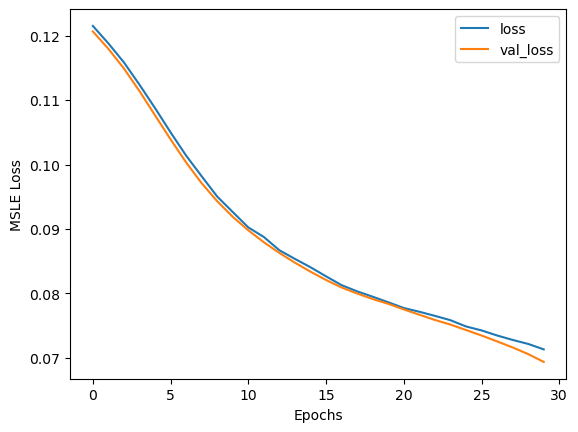

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [28]:
#define a function in order to plot the original data and reconstructed ones and also show the error
def plot(data, n):
    enc_img = model.encoder(data)
    dec_img = model.decoder(enc_img)
    plt.plot(data[n], 'b')
    plt.plot(dec_img[n], 'r')
    plt.fill_between(np.arange(6), data[n], dec_img[n], color = 'lightcoral')
    plt.legend(labels=['Input', 'Reconstruction', 'Error'])
    plt.show()

plot(X_test_anomaly, 0)
plot(X_test_non_anomaly, 0)

AttributeError: 'tuple' object has no attribute 'rank'

In [19]:
def find_threshold(model, x_train_scaled):
    reconstructions = model.predict(x_train_scaled)
    # provides losses of individual instances
    reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
    # threshold for anomaly scores
    threshold = np.mean(reconstruction_errors.numpy()) \
        + np.std(reconstruction_errors.numpy())
    return threshold

def get_predictions(model, x_test_scaled, threshold):
    predictions = model.predict(x_test_scaled)
    # provides losses of individual instances
    errors = tf.keras.losses.msle(predictions, x_test_scaled)
    # 0 = anomaly, 1 = normal
    anomaly_mask = pd.Series(errors) > threshold
    preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
    return preds

threshold = find_threshold(model, X_train_non_anomaly)
print(f"Threshold: {threshold}")
predictions = get_predictions(model, X_test, threshold)
accuracy_score(predictions, y_test)

2022-10-23 22:16:08.533712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Threshold: 0.03552712362958848


0.095

In [29]:
plot(X_test, 0)
plot(X_test, 4)

AttributeError: 'tuple' object has no attribute 'rank'